In [1]:
%load_ext autoreload
%autoreload 2

import src.ksd.models as models
from src.ksd.find_modes import find_modes, pairwise_directions, run_bfgs
from src.ksd.langevin import RandomWalkMH, RandomWalkBarker
import src.ksd.langevin as mcmc
from src.ksd.ksd import KSD
from src.ksd.kernel import IMQ
from src.ksd.bootstrap import Bootstrap
from src.ksd.find_modes import find_modes, pairwise_directions
from tqdm.notebook import tqdm, trange

import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
import matplotlib.pyplot as plt
import seaborn as sns

import kgof.density as density
import kgof.data as data

MCMCKernel = RandomWalkMH # RandomWalkBarker 

In [23]:
n = 1000
dim = 1

mean1 = tf.constant([[0.]])
mean2 = tf.constant([[8.]])
noise_mean = tf.constant([[6.]])

In [24]:
tf.random.set_seed(1)

In [25]:
sample_q = tf.random.normal((n, dim))
sample_p = tf.concat([
    tf.random.normal((n//2, dim)) + mean1,
    tf.random.normal((n//2, dim)) + mean2
], axis=0)

noise = tf.random.normal((n, dim)) + noise_mean
conv_sample_q = sample_q + noise
conv_sample_p = sample_p + noise

In [26]:
res = pd.DataFrame({
    "x": tf.concat([sample_q, conv_sample_q, sample_p, conv_sample_p], axis=0).numpy()[:, 0],
    "type": np.repeat(["q", "conv q", "p", "conv p"], n) 
})

<AxesSubplot:xlabel='x', ylabel='Count'>

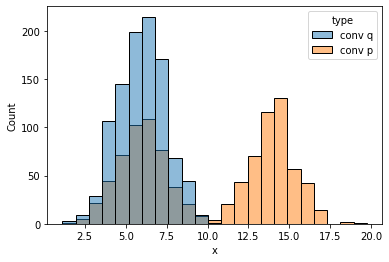

In [30]:
sns.histplot(data=res.loc[res.type.isin(["conv q", "conv p"])], x="x", hue="type")

# All modes

In [86]:
tf.random.set_seed(0)

In [45]:
dim = 2

# k = 2
# delta = 8.
# ratio_sample = 0.3
# ratio_target = 0.5

# target, log_prob_fn = models.create_mixture_gaussian_kdim(
#     dim=dim, k=k, delta=delta, return_logprob=True, ratio=ratio_target)
# proposal_off, log_prob_off_fn = models.create_mixture_gaussian_kdim(
#     dim=dim, k=k, delta=delta, return_logprob=True, ratio=ratio_sample)

## RBM
dh = 2
c_off = tf.concat([tf.ones(2) * 1., tf.zeros(dh-2)], axis=0)
target, log_prob_fn = models.create_rbm(c=0., dx=dim, dh=dh, burnin_number=2000, return_logprob=True)
proposal_off, log_prob_off_fn = models.create_rbm(c=c_off, dx=dim, dh=dh, burnin_number=2000, return_logprob=True)

In [46]:
n = 1000
samples_on = target.sample(n)
samples_on_df = pd.DataFrame({f"x{i}": samples_on[:, i] for i in range(dim)})
samples_on_df["type"] = "on"

samples_off = proposal_off.sample(n)
samples_off_df = pd.DataFrame({f"x{i}": samples_off[:, i] for i in range(dim)})
samples_off_df["type"] = "off"

samples_df = pd.concat([samples_on_df, samples_off_df], ignore_index=True)

<AxesSubplot:xlabel='x0', ylabel='x1'>

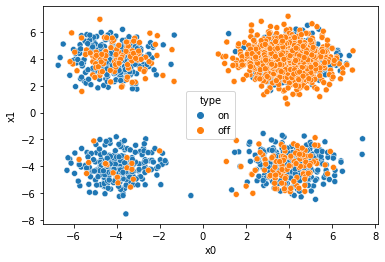

In [47]:
sns.scatterplot(data=samples_df, x="x0", y="x1", hue="type")

In [73]:
ntrain = n // 2
threshold = 1.

# samples_init = samples_off
samples_init = samples_on

sample_off_train, sample_off_test = samples_init[:ntrain, ], samples_init[ntrain:, ]

start_pts = sample_off_train
mode_list, inv_hess_list = find_modes(start_pts, log_prob_fn, grad_log=None, threshold=threshold)

In [74]:
proposal_dict = mcmc.prepare_proposal_input_all(mode_list=mode_list, inv_hess_list=inv_hess_list)

In [75]:
_, ind_pair_list = pairwise_directions(mode_list, return_index=True)

In [76]:
std = .8

In [100]:
T = 50

mh = MCMCKernel(log_prob=log_prob_fn)
mh.run(steps=T, std=std, x_init=sample_off_train, ind_pair_list=ind_pair_list, **proposal_dict)

<AxesSubplot:xlabel='x0', ylabel='x1'>

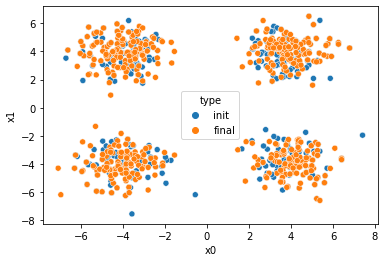

In [101]:
x_0 = mh.x[0, :, :].numpy()
x_t = mh.x[-1, :, :].numpy()

x0_df = pd.DataFrame({f"x{i}": x_0[:, i] for i in range(dim)})
x0_df["type"] = "init"

xt_df = pd.DataFrame({f"x{i}": x_t[:, i] for i in range(dim)})
xt_df["type"] = "final"

perturbed_df = pd.concat([x0_df, xt_df], ignore_index=True)

sns.scatterplot(data=perturbed_df, x="x0", y="x1", hue="type")

In [102]:
np.mean((x_t[:, 0] > 0.) & (x_t[:, 1] > 0.))

0.25

In [98]:
num_boot = 800
alpha = 0.05
nrep = 1

kernel = IMQ(med_heuristic=True)
ksd = KSD(target=target, kernel=kernel)
bootstrap = Bootstrap(ksd, n//2)

In [84]:
multinom_samples = bootstrap.multinom.sample((nrep, num_boot))
multinom_one_sample = multinom_samples[0, :]

In [103]:
_, p_val = bootstrap.test_once(alpha=alpha, num_boot=num_boot, X=x_t, multinom_samples=multinom_one_sample)
p_val

0.6292134831460674

In [ ]:
def repeat_experiment(nrep, B_scale):    
    off_target2, log_prob_off_fn2 = models.create_rbm(
        B_scale=B_scale, c=c_loc_off, dx=dim, dh=dh, return_logprob=True, burnin_number=2000)

    num_boot = 800
    alpha = 0.05

    kernel = IMQ(med_heuristic=True)
    ksd = KSD(target=off_target2, kernel=kernel)
    bootstrap = Bootstrap(ksd, n)
    
    multinom_samples = bootstrap.multinom.sample((nrep, num_boot))
    multinom_one_sample = multinom_samples[0, :]
    
    p_val_list = []
    for i in trange(nrep):
        off_sample2 = off_target2.sample(n)
        syn_sample = off_sample2 #!
    
        kernel = IMQ(med_heuristic=True)
        ksd = KSD(target=off_target2, kernel=kernel)
        bootstrap = Bootstrap(ksd, n)
        
        multinom_one_sample = multinom_samples[i, :]
        
        _, p_val2 = bootstrap.test_once(alpha=alpha, num_boot=num_boot, X=off_sample2, multinom_samples=multinom_one_sample)
        _, p_val_sync = bootstrap.test_once(alpha=alpha, num_boot=num_boot, X=syn_sample, multinom_samples=multinom_one_sample)

        p_val_list.append((p_val2, "builtin"))
        p_val_list.append((p_val_sync, "synthetic"))
        
    res = pd.DataFrame(p_val_list, columns=["pval", "type"])
    return res